In [1]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

- True population distribution

$$ X_i \sim p_\text{T}(x) = \mathcal{N}(0,1)$$

- Measurements distribution

$$ X_i^{(m)} \sim p_m(x) = p(x^{(m)} | x) = \mathcal{N}(x^{(m)}, \mu=x,\sigma=\sigma_\text{N})$$

- Model

$$ p(x | \vec{w}) = \sum_{i=1}^{N_w} w_i \delta(x - \hat{x}_i)$$

- We would like to understand which are the most probable weights given the data

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w})$$

- The right thing to do would be to sample $\vec{w}$ according to $p(\vec{w} | \{x_i^{(m)}\})$
- Alternatively

$$\vec{w}_\text{MAP} = \argmax_{\vec{w}} p(\vec{w} | \{x_i^{(m)}\})$$

- Study the distribution

$$ p(x)_\text{MAP} = p(x | \vec{w}_\text{MAP}) = \sum_{i=1}^{N_w} w_{(\text{MAP}), i} \delta(x - \hat{x}_i)$$

- Let's introduce the moments

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w} | \vec{m})\;p(\vec{m})$$

- One could use the maximum entropy principle and maximize the entropy of the above expression subject to contraints

$$ \langle \log p(\vec{w}, \vec{m} | \{x_i^{(m)}\})\rangle_p \propto \langle \log p(\{x_i^{(m)}\} | \vec{w}) \rangle_p + \langle \log p(\vec{w} | \vec{m}) \rangle_p + \langle \log p(\vec{m}) \rangle_p + \sum_k \lambda_k \left(\sum_{i=1}^{N_w} w_i \hat{x}_i^k - m_k\right)$$

- For now we use 

$$ p(\{x_i^{(m)}\} | \vec{w}) = \int \text{d} x\, p(\{x_i^{(m)}\}, x | \vec{w}) = \prod_{i=1}^N \int \text{d} x\, p(x_i^{(m)} | x)\; p(x | \vec{w}) = \prod_{i=1}^N \sum_{j=1}^{N_w} w_j p(x_i^{(m)}| \hat{x}_j) = \prod_{i=1}^N \sum_{j=1}^{N_w} L_{ij} w_j$$

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w} | \vec{m})\;p(\vec{m})$$


In [2]:
from scipy.stats import norm

N, M = 2 ** 8, 2 ** 0
sigma_noise = 2

p_true = lambda x: norm.pdf(x, loc=0, scale=1)
p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.random.normal(loc=0, scale=1, size=N)
X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 2 ** 3
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

In [3]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift

def ContinuousFT(f, x):
    """
    Approximates the continuous Fourier transform: phi(f) ≈ ∫ f(x) exp(-i 2π f x) dx
    using FFT on a symmetric grid around 0.
    Input: f values on increasing x grid (e.g., linspace(-L/2, L/2, N)).
    Output: phi at sorted increasing ordinary frequencies fs (negative to positive).
    """
    dx = x[1] - x[0]
    N = len(x)
    shift_amount = N // 2
    f_for_fft = np.roll(f, -shift_amount)
    phi = fft(f_for_fft) * dx
    phi_shifted = fftshift(phi)
    fs_shifted = fftshift(fftfreq(N, d=dx))
    sort_idx = np.argsort(fs_shifted)
    return phi_shifted[sort_idx], fs_shifted[sort_idx]

def ContinuousFTM1(phi, fs):
    """
    Approximates the inverse continuous Fourier transform: f(x) ≈ ∫ phi(f) exp(i 2π f x) df
    using IFFT, returning real part (assuming real-valued f).
    Input: phi values at sorted increasing fs grid.
    Output: f at increasing x grid symmetric around 0.
    """
    df = fs[1] - fs[0]
    N = len(fs)
    phi_unshift = ifftshift(phi)
    f_complex = ifft(phi_unshift) * N * df
    shift_amount = N // 2
    f_rolled = np.roll(f_complex, shift_amount)
    dx_back = 1 / (N * df)
    half_N = N // 2
    xs = np.linspace(-half_N * dx_back, (half_N - 1) * dx_back, N)
    return np.real(f_rolled), xs

## Quadrature Weights Fluctuations

- Let's define the *moment-orthogonal* polynomials as

$$\langle q_{n}^{\left(k\right)}\left(\xi\right)\xi^{p}\rangle_{\omega}=\delta_{pk},\qquad p\leq n,$$
$$q_{n}^{\left(k\right)}\left(\xi\right)=\sum_{m=0}^{n}\alpha_{m}^{\left(k\right)}\xi^{m},\qquad \alpha_{r}^{\left(k\right)}=\left[\mathrm{H}^{\left(n\right)}\right]_{rk}^{-1},$$

- Let's define the fluctuating weights

$$\hat{w}_{i}=\frac{w_{i}}{Z}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]$$

with the normalization that can be expanded to second order

$$\begin{split}&Z=\sum_{i=1}^{N}w_{i}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]\simeq\sum_{i=1}^{N}w_{i}\left(1+\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\delta m_{r}\delta m_{s}\right)\\&=\langle1\rangle_{w}+\sum_{p=0}^{n}\langle q_{n}^{\left(p\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}\langle q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{r}\delta m_{s}\\&=1+\delta m_{0}+\frac{1}{2}\sum_{r,s=0}^{n}\alpha_{r}^{\left(s\right)}\delta m_{r}\delta m_{s}=1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s},\qquad\delta m_{0}=0\end{split}$$

yielding

$$Z\simeq1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}$$

- Let's look at the logarithm of the weights

$$\log\hat{w}_{i}=-\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}+\sum_{p=1}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\log w_{i}$$

## Generalized non-centered $\chi^2$

$$\begin{split}&Y=\mathbf{X}^{\top}A\mathbf{X}=\sum_{k=1}^{n}\lambda_{k}U_{k}^{2},\qquad\mathbf{X}\sim\mathcal{N}\left(\boldsymbol{\nu},C\right),\qquad U_{k}\sim\mathcal{N}\left(\eta_{k},1\right),\qquad\eta_{k}=P_{kr}^{\top}S_{rs}^{-1}\nu_{s},\qquad S=\left[C\right]^{1/2},\qquad S^{\top}AS=P\Gamma P^{\top}\\&\phi_{Y}\left(t\right)=\prod_{k=1}^{n}\phi_{\lambda_{k}Z^{2}}\left(t\right)=\prod_{k=1}^{n}\frac{1}{\sqrt{1-2\imath\lambda_{k}t}}\exp\left(\frac{\imath\lambda_{k}\eta_{k}^{2}t}{1-2\imath\lambda_{k}t}\right)\end{split}$$

In [4]:
dim = 2
nu = np.random.uniform(size=dim)
C = np.random.uniform(size=(dim, dim))
C = (C.T + C) * 0.5

A = np.random.uniform(size=(dim, dim))
A = (A.T + A) * 0.5

C, A

(array([[0.82350119, 0.68682752],
        [0.68682752, 0.59950896]]),
 array([[0.08245299, 0.30351616],
        [0.30351616, 0.24385918]]))

In [5]:
dim = 2
# nu = np.random.uniform(size=dim)

# C = np.random.randn(dim, dim)
# C = np.dot(C.T, C) + np.eye(dim) * 1e-6

# A = np.random.randn(dim, dim)
# A = np.dot(A.T, A) + np.eye(dim) * 1e-6

A = np.array([[1, 0], [0, 1]])
nu = np.array([1, 1])
C = np.array([[1, 0], [0, 1]])

Lambda_C, O_C = np.linalg.eig(C)

print(Lambda_C, O_C)

S = O_C.T @ np.diag(np.sqrt(Lambda_C)) @ O_C

Sm1 = np.linalg.inv(S)

Lambdas, P = np.linalg.eig(S.T @ A @ S)
Etas = P.T @ Sm1 @ nu

phi_t_lams = [lambda t: (1 / np.sqrt(1 - 2 * 1j * lam * t)) * np.exp((1j * lam * (eta ** 2) * t) / (1 - 2 * 1j * lam * t)) for lam, eta in zip(Lambdas, Etas)]

def PhiY(t, phi_t_lams=phi_t_lams):
    res = 1
    for phi in phi_t_lams:
        res *= phi(t)
    return res

[1. 1.] [[1. 0.]
 [0. 1.]]


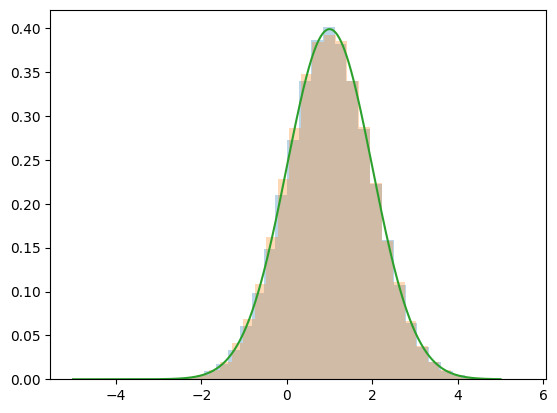

In [6]:
from scipy.stats import norm

sample_N = 2 ** 17
X_sample = np.array(np.random.multivariate_normal(nu, C, size=sample_N).squeeze())

gauss_range = np.linspace(-5, 5, 2 ** 10)
gauss_f = lambda x: norm.pdf(x, loc=nu[1], scale=np.sqrt(C[1, 1]))

plt.figure()
_ = plt.hist(X_sample[:, 0], density=True, bins=2**5, alpha=0.3)
_ = plt.hist(X_sample[:, 1], density=True, bins=2**5, alpha=0.3)
plt.plot(gauss_range, gauss_f(gauss_range))

Y_sample = np.array([X @ (A @ X) for X in X_sample])


Mean Y_0: 3.923 (expected ~0.636)
Var Y_0: 11.378 (expected ~0.160)
Mode Y_0: 0.006
PDF(0): 0.093


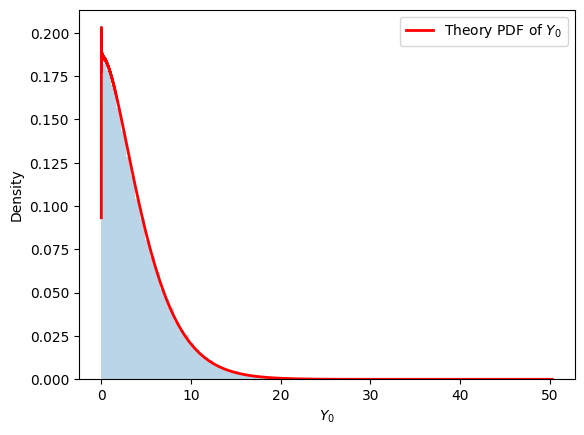

In [8]:
N = 2 ** 14
t_max = 2 ** 9 # Reasonable range for |t|; increase for tails
fs = np.linspace(-t_max / (2 * np.pi), t_max / (2 * np.pi), N)
# Flip arg for correct phase (matches e^{-i t y} convention)
phi_input = np.array([PhiY(2 * np.pi * (-f)) for f in fs])
pdf_full, y_grid_full = ContinuousFTM1(phi_input, fs)

# Extract positive y (Y_i >0), normalize
pos_mask = y_grid_full >= 0
pdf_y = pdf_full[pos_mask]
y_grid = y_grid_full[pos_mask]
integ_pos = np.trapezoid(pdf_y, y_grid)
pdf_y /= integ_pos  # Ensures ∫ pdf_y dy =1

# Quick validation: moments
mean_y = np.trapezoid(y_grid * pdf_y, y_grid)
var_y = np.trapezoid(y_grid**2 * pdf_y, y_grid) - mean_y**2
print(f"Mean Y_0: {mean_y:.3f} (expected ~0.636)")
print(f"Var Y_0: {var_y:.3f} (expected ~0.160)")
print(f"Mode Y_0: {y_grid[np.argmax(pdf_y)]:.3f}")
print(f"PDF(0): {pdf_y[0]:.3f}")

# Plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(y_grid, pdf_y, 'r-', linewidth=2, label='Theory PDF of $Y_0$')
_ = plt.hist(Y_sample, density=True, bins=2**6, alpha=0.3)
# plt.yscale('log')
# plt.xlim(0, 3)  # Focus on main support
plt.xlabel('$Y_0$')
plt.ylabel('Density')
plt.legend()
plt.show()

## Gaussian Quadratures - $p(\hat{w})$

w_i: [0.16666667 0.66666667 0.16666667]
hat_x_i: [-1.73205081  0.          1.73205081]
kBT_max: 0.07071067811865475


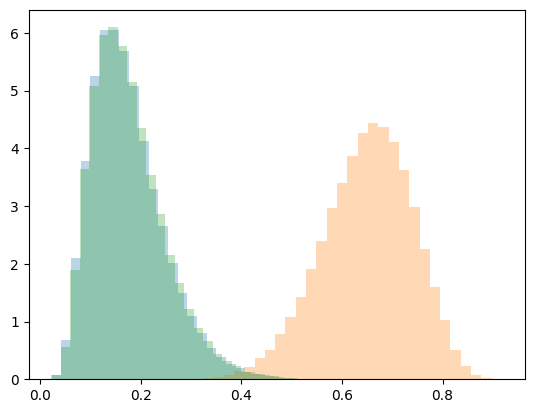

In [4]:
def GaussMs(k):
    if k == 0:
        return 1.0
    if k % 2 == 1:
        return 0
    else:
        return float(sp.factorial2(k - 1))

q_degree = 2
"""
Quadrature first, hat_x_i, w_i ... what a waste
"""
gauss_degree = q_degree + 1

H = np.array([[GaussMs(i + j) for j in range(gauss_degree + 1)] for i in range(gauss_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(gauss_degree + 1)]) for i in range(gauss_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])
orthogonal_poly_cs = q_polys_c_np[-1]

hat_x_i = np.sort(np.roots(orthogonal_poly_cs))

VMM = np.array([[x ** p for p in range(gauss_degree)] for x in hat_x_i])
VMM_det = np.linalg.det(VMM)
VMM_i = lambda i: np.array([H[0,:gauss_degree] if i == j else [x ** p for p in range(gauss_degree)]for j, x in enumerate(hat_x_i)])
VMM_i_det = lambda i: np.linalg.det(VMM_i(i))

w_i = np.array([VMM_i_det(i) / VMM_det for i in range(gauss_degree)])

print("w_i:", w_i)
print("hat_x_i:", hat_x_i)

"""
Moment-orthogonal polynomials
"""
H = np.array([[GaussMs(i + j) for j in range(q_degree + 1)] for i in range(q_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(q_degree + 1)]) for i in range(q_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])

q_polys_lams = [lambda x, c=cs: np.polyval(c, x) for cs in q_polys_c_np]
q_poly_evals = np.array([f(hat_x_i) for f in q_polys_lams])
q_poly_evals_T = q_poly_evals.T

"""
Preparing the correlations for the Moment Lattice Model
"""
def GetCpq(P, ms_lam):
    ms_dict_P = {p: ms_lam(p) for p in range(1, 2 * P + 1, 1)}
    num_lam = lambda p, q: ms_dict_P[p + q] - ms_dict_P[p] * ms_dict_P[q]
    den_lam = lambda p, q: np.sqrt((ms_dict_P[2 * p] - (ms_dict_P[p] ** 2)) * (ms_dict_P[2 * q] - (ms_dict_P[q] ** 2)))
    Cpq = np.array([[num_lam(p, q) / den_lam(p, q) for q in range(1, P + 1)] for p in range(1, P + 1)])
    return Cpq

Cpq = GetCpq(q_degree, GaussMs)

def FindMaxKBT(P, ms_lam, GL_ratio=0.1):
    ratios_mm2 = np.array([ms_lam(p) / np.sqrt((ms_lam(2 * p) - (ms_lam(p) ** 2))) for p in range(1, P + 1)])
    ratios_mm2 = ratios_mm2[ratios_mm2 > 0]
    beta_min = 1 / np.sort(ratios_mm2)[0]
    kBT_max = (1 / beta_min) * GL_ratio

    return kBT_max

kBT_max = FindMaxKBT(q_degree, GaussMs)

print("kBT_max:", kBT_max)

def SqrtVar(p, ms_lam, kBT=1):
    return np.sqrt(kBT * (ms_lam(2 * p) - (ms_lam(p) ** 2)))

def GetDeltaMs(Cpq, ms_lam, kBT, size=1):
    P_ms = Cpq.shape[0]
    phi_p = np.array(np.random.multivariate_normal([0] * P_ms, Cpq, size=size).squeeze())
    return np.array([0] + list(phi_p * np.array([SqrtVar(p, ms_lam, kBT) for p in range(1, P_ms + 1)])))

def HatWRnd(Cpq, ms_lam, kBT, size=1):
    hat_w_i = w_i * np.exp(q_poly_evals_T @ GetDeltaMs(Cpq, ms_lam, kBT, size=size))
    return hat_w_i / np.sum(hat_w_i)

kBT, n_hat_samples = kBT_max * 0.5, 2 ** 17
hat_w_sample = np.array([HatWRnd(Cpq, GaussMs, kBT) for k in range(n_hat_samples)])

sqrt_kBT_scale = np.diag(np.array([SqrtVar(p, GaussMs, kBT_max) for p in range(1, q_degree + 1)]))
Hm1_T_pruned = Hm1_T[1:, 1:]
H_pruned = H[1:, 1:]

AC_m = (Hm1_T_pruned @ (sqrt_kBT_scale @ Cpq @ sqrt_kBT_scale))
Lambda, Q = np.linalg.eig(AC_m)

A_inv = np.linalg.inv(Hm1_T_pruned)
etas = - Q.T @ A_inv @ q_poly_evals[1:,:]

# etas = - Q.T @ H_pruned @ q_poly_evals[1:,:]

plt.figure()

for i in range(len(w_i)):
    _ = plt.hist((hat_w_sample[:, i]), density=True, bins=2**5, alpha=0.3)
    
# plt.yscale('log')
# plt.xscale('log')